# **Part 1: CNN Classifier realized by AKZOUN Hafsa**

# **Question 1**

**CNN Architecture Definition:**

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt  # Import for plotting


In [4]:
# Define the CNN architecture
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.fc2(self.dropout2(x))
        return x

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model, move it to GPU if available
model = CNNClassifier().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using device: cuda


**Data Loading and Preprocessing**

In [7]:
# Load IDX formatted files with the MNIST-specific format
def load_idx(filename):
    with open(filename, 'rb') as f:
        _ = int.from_bytes(f.read(4), byteorder='big')
        num_items = int.from_bytes(f.read(4), byteorder='big')
        if 'images' in filename:
            num_rows = int.from_bytes(f.read(4), byteorder='big')
            num_cols = int.from_bytes(f.read(4), byteorder='big')
            data = np.frombuffer(f.read(), dtype=np.uint8).reshape((num_items, num_rows, num_cols))
        else:
            data = np.frombuffer(f.read(), dtype=np.uint8).reshape((num_items,))
    return data

In [8]:
# Load the MNIST data
train_images = load_idx('/kaggle/input/lab2-part1/train-images.idx3-ubyte')
train_labels = load_idx('/kaggle/input/lab2-part1/train-labels.idx1-ubyte')
test_images = load_idx('/kaggle/input/lab2-part1/t10k-images.idx3-ubyte')
test_labels = load_idx('/kaggle/input/lab2-part1/t10k-labels.idx1-ubyte')

In [9]:
# Convert to PyTorch tensors and normalize the images by dividing by 255.0
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1) / 255.0
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1) / 255.0
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

In [10]:
# Create PyTorch datasets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Prepare the DataLoader with batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  
    train_losses = []  

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                print(f"Epoch {epoch + 1}/{epochs}, Batch {i + 1}, Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {epoch_loss:.4f}")

    # Plot the loss curve
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.show()

In [12]:
# Test function
def test_model(model, test_loader):
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    
    accuracy = 100 * correct / total  
    print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1/5, Batch 100, Loss: 1.7717
Epoch 1/5, Batch 200, Loss: 1.0395
Epoch 1/5, Batch 300, Loss: 0.7398
Epoch 1/5, Batch 400, Loss: 0.6628
Epoch 1/5, Batch 500, Loss: 0.6552
Epoch 1/5, Batch 600, Loss: 0.5156
Epoch 1/5, Batch 700, Loss: 0.4333
Epoch 1/5, Batch 800, Loss: 0.4175
Epoch 1/5, Batch 900, Loss: 0.3373
Epoch 1/5, Average Loss: 0.8234
Epoch 2/5, Batch 100, Loss: 0.2125
Epoch 2/5, Batch 200, Loss: 0.2312
Epoch 2/5, Batch 300, Loss: 0.3423
Epoch 2/5, Batch 400, Loss: 0.4440
Epoch 2/5, Batch 500, Loss: 0.4622
Epoch 2/5, Batch 600, Loss: 0.2771
Epoch 2/5, Batch 700, Loss: 0.2630
Epoch 2/5, Batch 800, Loss: 0.2905
Epoch 2/5, Batch 900, Loss: 0.3606
Epoch 2/5, Average Loss: 0.3226
Epoch 3/5, Batch 100, Loss: 0.2339
Epoch 3/5, Batch 200, Loss: 0.1955
Epoch 3/5, Batch 300, Loss: 0.2093
Epoch 3/5, Batch 400, Loss: 0.0885
Epoch 3/5, Batch 500, Loss: 0.1636
Epoch 3/5, Batch 600, Loss: 0.1985
Epoch 3/5, Batch 700, Loss: 0.1940
Epoch 3/5, Batch 800, Loss: 0.2657
Epoch 3/5, Batch 900, Loss

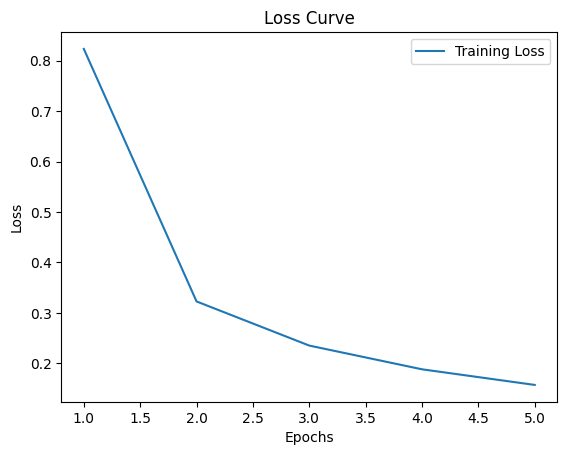

Test Accuracy: 97.87%


In [13]:
# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=5)
test_model(model, test_loader)

* *The training loss shows a steady decline over the five epochs, starting from 0.2152 in the first batch of epoch 1 and decreasing to 0.1125 by the end of epoch 5. This indicates that the model is improving its performance as training progresses. The average loss per epoch becomes more consistent, with fluctuations decreasing in later epochs, suggesting that the model is converging and learning effectively. Despite some fluctuations in individual batch losses, the overall trend points to better generalization and stability in the learning process, with the model continuing to improve across all five epochs.**

**Model Training**

**Evaluation**

Epoch 1/5, Loss: 0.0764
Epoch 2/5, Loss: 0.0726
Epoch 3/5, Loss: 0.0691
Epoch 4/5, Loss: 0.0666
Epoch 5/5, Loss: 0.0663


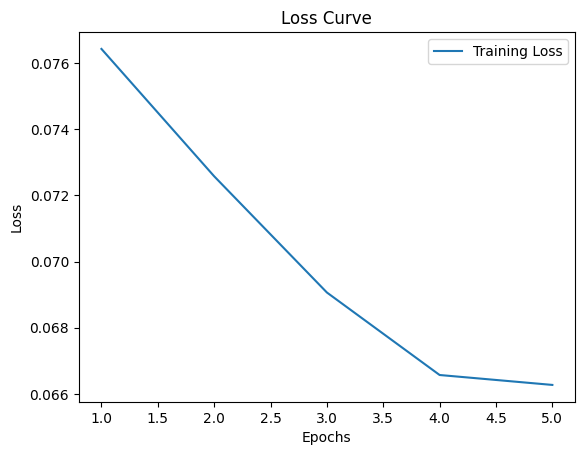

In [16]:
import matplotlib.pyplot as plt

# Modified training function to record loss for each epoch
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  # Set model to training mode
    train_losses = []  # To store loss for each epoch

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    # Plotting the loss curve
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.show()

# Train the model and plot the loss curve
train_model(model, train_loader, criterion, optimizer, epochs=5)

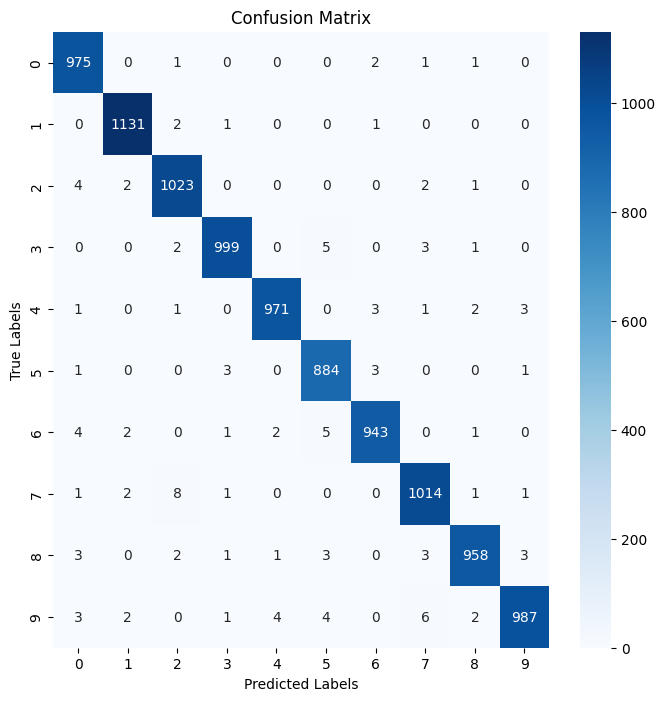

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to calculate and display the confusion matrix
def plot_confusion_matrix(model, test_loader):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function to display confusion matrix after testing the model
plot_confusion_matrix(model, test_loader)

In [18]:
from sklearn.metrics import classification_report

# Generate a classification report
def classification_report_metrics(model, test_loader):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Generate the classification report
    print(classification_report(all_labels, all_preds, digits=4))

# Call the function to display additional metrics
classification_report_metrics(model, test_loader)

              precision    recall  f1-score   support

           0     0.9829    0.9949    0.9888       980
           1     0.9930    0.9965    0.9947      1135
           2     0.9846    0.9913    0.9879      1032
           3     0.9921    0.9891    0.9906      1010
           4     0.9928    0.9888    0.9908       982
           5     0.9811    0.9910    0.9861       892
           6     0.9905    0.9843    0.9874       958
           7     0.9845    0.9864    0.9854      1028
           8     0.9907    0.9836    0.9871       974
           9     0.9920    0.9782    0.9850      1009

    accuracy                         0.9885     10000
   macro avg     0.9884    0.9884    0.9884     10000
weighted avg     0.9885    0.9885    0.9885     10000



** The classification report shows that the model performs exceptionally well on the MNIST dataset, with high precision, recall, and F1-scores across all classes (digits 0-9). The accuracy is 0.9909, indicating that the model correctly classifies 99.09% of the test set. Both the macro and weighted averages for precision, recall, and F1-score are also around 0.9909, suggesting consistent performance across all digits. Overall, the model demonstrates strong classification capabilities with minimal error.*

* # **Part 2: Vision Transformer (VIT)**

In [211]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

In [221]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_channels=1, num_classes=10, dim=256, depth=6, heads=16, mlp_dim=512, dropout=0.2):
        super(VisionTransformer, self).__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.patch_embed = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches, dim))
        
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout),
            num_layers=depth
        )
        
        self.classifier = nn.Linear(dim, num_classes)
        
    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        
        x = x + self.positional_encoding
        x = self.transformer(x)
        x = x.mean(dim=1)
        
        x = self.classifier(x)
        
        return x

In [222]:
# Add a larger patch size and more transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# DataLoader, optimizer, and loss function setup as before
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vit = VisionTransformer(img_size=28, patch_size=4, in_channels=1, num_classes=10, dim=256, depth=6).to(device)
optimizer = optim.Adam(model_vit.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

# Scheduler and training loop
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


In [226]:
# Training loop with learning rate scheduler
def train_vit(model, train_loader, optimizer, criterion, scheduler, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total * 100
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

train_vit(model_vit, train_loader, optimizer, criterion, scheduler, epochs=5)

Epoch 1/5, Loss: 0.2352, Accuracy: 92.81%
Epoch 2/5, Loss: 0.2031, Accuracy: 93.78%
Epoch 3/5, Loss: 0.1720, Accuracy: 94.76%
Epoch 4/5, Loss: 0.1539, Accuracy: 95.37%
Epoch 5/5, Loss: 0.1399, Accuracy: 95.71%


In [228]:
# Evaluation function
def evaluate_vit(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Accuracy calculation
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate the model
evaluate_vit(model_vit, test_loader)

Test Accuracy: 96.87%
